# Examining new dataset from Zimmer lab

In this notebook, we examine a new fluorescent microscopy dataset recorded by Manuel Zimmer's lab.

Zimmer lab homepage: <https://www.imp.ac.at/groups/manuel-zimmer/>

In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

In [2]:
import h5py
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

from otimage.viewers import ImageSliceViewer3D
from otimage.utils import plot_img_units, plot_maxproj_units

## Load mCherry dataset from file

### Full file

This dataset is 28 GB in size, so we need to be careful how much of it we try to load at once. Due to storage constraints, this dataset is kept on a flash disk in the lab instead of being stored on the Koala machine.

#### Spec (copied from `README.md` file in Dropbox folder)

- Dataset Name: 'mCherry'
- No. of dimensions: 5 (v, c, z, y, x)
- Dimension Sizes: (1516, 1, 33, 650, 890)
- Max Dim. Size: (1516, 1, 33, 650, 890)
- Data Type: uint16
- Layout: CHUNKED (1, 1, 33, 650, 890)
- Compression: LZF
- Attributes:
  - `elementsizeum`: 3-element float64 array (µm) (z, y, x)
  
#### Unit sizes

- Units stored in `elementsizeum` are **not** correct units
- Emailed Rey Torne from Zimmer Lab on 2019-11-15, and he gave us the following units: $X: 0.325\mu m, Y: 0.325\mu m, Z: 1.0 \mu m$

### Sample file

This dataset is significantly smaller, and containst the first 50 frames of the full dataset. It is stored on the Koala machine, and used for most analyses involving Zimmer data for convenience.

#### Spec 

- Dataset Name: 'mCherry'
- No. of dimensions: 5 (v, c, z, y, x)
- Dimension Sizes: (50, 1, 33, 650, 890)
- Max Dim. Size: (50, 1, 33, 650, 890)
- Data Type: uint16
- Layout: CHUNKED (1, 1, 33, 650, 890)
- Compression: LZF
- Attributes: None
 

## Parameters

In [3]:
# Path to sample mCherry file
IN_FPATH = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'

# Voxel size (microns)
UNITS = np.array([0.325, 0.325, 1.0])

## Examine worm head for single frame

### Load frame

In [4]:
# Frame index
t_frame = 1

with h5py.File(IN_FPATH, 'r') as f:
    
    dset = f.get('mCherry')
    frame = dset[t_frame, 0, :, :, :]
    frame = np.moveaxis(frame, [0, 1, 2], [2, 1, 0])

### Plot max. projection of zoomed-in head

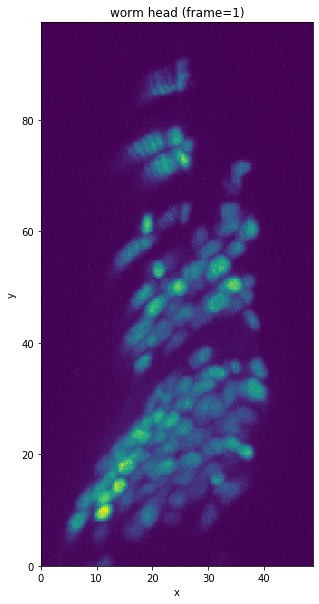

In [5]:
# Voxel coordinates for head region in frame
head_x = (475, 625)
head_y = (250, 550)
head_z = (0, 33)

img = frame[head_x[0]:head_x[1], head_y[0]:head_y[1], head_z[0]:head_z[1]]

plt.figure(figsize=(10, 10))
plot_maxproj_units(img, UNITS)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'worm head (frame={t_frame})');

#plt.savefig('zimmer_1.png')

### Use slice viewer to look at 3D structure of head image

In [6]:
ImageSliceViewer3D(np.swapaxes(img, 0, 1), origin='lower');

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

### Create videos of max-projected worm motion

#### Parameters

In [7]:
t_start = 0
t_end = 50
threshold = 250

#### Get max- and argmax-projected frames

In [8]:
with h5py.File(IN_FPATH, 'r') as f:
    
    dset = f.get('mCherry')
    
    frames_mp = []
    frames_am = []
    frames_sp = []
   
    for t in range(t_start, t_end):
        
        frame = dset[t, 0, :, :, :]
        
        # Compute max projection
        mp_frame = np.max(frame, 0)
        frames_mp.append(mp_frame)
       
        # Compute 'argmax projection'
        am_frame = np.argmax(frame, 0)
        am_frame[mp_frame < threshold] = 0
        frames_am.append(am_frame)
                
        # Compute sum projection
        sp_frame = np.sum(frame, 0)
        frames_sp.append(sp_frame)
 

### Create max-projected video

In [10]:
# Create figure for animation
fig, ax = plt.subplots(figsize=(10, 10))

def animate(t):
    ax.set_title(f'frame: {t}')
    plot_img_units(frames_mp[t], UNITS, ax=ax, animated=True)
    
ani = animation.FuncAnimation(fig, animate, len(frames_mp))

# Display animation in notebook
plt.close()
HTML(ani.to_html5_video())

#ani.save('zimmer_maxproj.mp4', fps=10)

### Create max-projected video with color-coded depth

In [11]:
# Create figure for animation
fig, ax = plt.subplots(figsize=(10, 10))

def animate(t):
    ax.set_title(f'frame: {t}')
    plot_img_units(frames_am[t], UNITS, ax=ax, animated=True)
    
ani = animation.FuncAnimation(fig, animate, len(frames_am))

# Display animation in notebook
plt.close()
HTML(ani.to_html5_video())

#ani.save('zimmer_mp_color.mp4', fps=10)

### Create sum-projected video

In [13]:
# Create figure for animation
fig, ax = plt.subplots(figsize=(10, 10))

def animate(t):
    ax.set_title(f'frame: {t}')
    plot_img_units(frames_sp[t], UNITS, ax=ax, animated=True)
    
ani = animation.FuncAnimation(fig, animate, len(frames_sp))

# Display animation in notebook
plt.close()
HTML(ani.to_html5_video())

#ani.save('zimmer_sp.mp4', fps=10)